## Notebook de modélisation des données - Projet 3 - David Depouez

### 1. Généralités

Selection de la cible pour ce Notebook => **TotalGHGEmissions**

In [1]:
isEnergyTarget = False

if isEnergyTarget == False:
    targetName = 'SiteEnergyUse(kBtu)'
else:
    targetName = 'TotalGHGEmissions'

Importation des modules et lecture du fichier de données

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import shap

In [3]:
path = "./data/cleaned/"

filename = "Cleaned-2016_Building_Energy_Benchmarking.csv"

df = pd.read_csv(path+filename)
df.shape

(1650, 46)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   YearBuilt                    1650 non-null   float64
 1   NumberofBuildings            1650 non-null   float64
 2   NumberofFloors               1650 non-null   float64
 3   PropertyGFATotal             1650 non-null   float64
 4   ENERGYSTARScore              1650 non-null   float64
 5   SourceEUI(kBtu/sf)           1650 non-null   float64
 6   SiteEnergyUse(kBtu)          1650 non-null   float64
 7   SteamUse(kBtu)               1650 non-null   float64
 8   Electricity(kBtu)            1650 non-null   float64
 9   NaturalGas(kBtu)             1650 non-null   float64
 10  TotalGHGEmissions            1650 non-null   float64
 11  BALLARD                      1650 non-null   float64
 12  CENTRAL                      1650 non-null   float64
 13  DELRIDGE          

Séparation du jeu de donnés pour l'apprentissage

In [5]:
from sklearn.model_selection import train_test_split

dfTrain, dfTest = train_test_split(df, train_size=0.8,random_state=87)
dfTrain.shape , dfTest.shape

((1320, 46), (330, 46))

### 2. Modélisations avec l'Energy Star Score

In [6]:
XTrain = dfTrain.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1 )
yTrain = dfTrain[targetName].copy()
XTest = dfTest.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'],axis=1 )
yTest = dfTest[targetName].copy()

On centre et on met à l'echelle les données

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xTrainScaled = scaler.fit_transform(XTrain)
xTestScaled = scaler.transform(XTest)

On définit une fonction pour retourner différentes metriques

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def getRegressionMetrics(ypredict, yreel,isDump = True) :
    ### Compute MSE, RMSE and R2  ###
    MSE = mean_squared_error(yreel, ypredict)
    RMSE = mean_squared_error(yreel, ypredict, squared=False)
    R2 = r2_score(yreel, ypredict)
    if isDump == True :
        print("MSE {:.2f} RMSE {:.2f} R2 {:.3f}".format(MSE,RMSE,R2))
    return (MSE, RMSE, R2)

#### Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression()
linear_regr.fit(xTrainScaled, yTrain)

yPredTrain = linear_regr.predict(xTrainScaled)
yPredTest = linear_regr.predict(xTestScaled)

In [10]:
msTrain,rmTrain,r2Train  = getRegressionMetrics(yPredTrain, yTrain)
msTest,rmTest,r2Test  = getRegressionMetrics(yPredTest, yTest)

MSE 5666946842432.28 RMSE 2380534.99 R2 0.772
MSE 5418813143075.91 RMSE 2327834.43 R2 0.784


In [11]:
# Store errors
Results = []
Results.append(['Linear Regression',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### RidgeCV

In [12]:
from sklearn.linear_model import RidgeCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

ridgeCV_regr = RidgeCV(alphas=alphas,
scoring='neg_mean_squared_error',
                 cv=fold_number)
ridgeCV_regr.fit(xTrainScaled, yTrain)
print('alpha = {}  best score = {}'.format(ridgeCV_regr.alpha_ , ridgeCV_regr.best_score_))
yPredtrain = ridgeCV_regr.predict(xTrainScaled)
print('Train best score = {}'.format(ridgeCV_regr.score(xTrainScaled,yTrain)))
yPredTest = ridgeCV_regr.predict(xTestScaled)
print('Test best score = {}'.format(ridgeCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

alpha = 475.0810162102793  best score = -7619581214401.1875
Train best score = 0.746712809794104
Test best score = 0.7526026435106102
MSE 6297665696777.88 RMSE 2509515.03 R2 0.747
MSE 6219610116112.96 RMSE 2493914.62 R2 0.753


In [13]:
# Store errors
Results.append(['RidgeCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Ridge  with Manual CV

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from numpy import mean , std

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

In [15]:
TabErrors = []
ridge_regr = Ridge()

for i,a in enumerate(alphas) :
    ridge_regr.set_params(alpha=a)
    scores = cross_validate(ridge_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)

#mini = [val[0] for i,val in enumerate(TabErrors) if val[1] == np.min(TabErrors,axis=0)[1]]
#mini

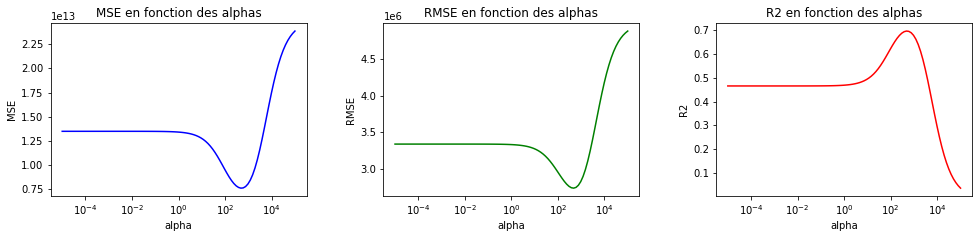

In [16]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

Get best params

In [17]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 99, RMSE 99,  R2 76
Best fit is for alpha = 475.0810162102793


Apply model with best params

In [18]:
ridge_regr.set_params(alpha=alphaBest)
ridge_regr.fit(xTrainScaled, yTrain)
yPredTrain = ridge_regr.predict(xTrainScaled)
yPredTest = ridge_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 6297665696777.88 RMSE 2509515.03 R2 0.747
MSE 6219610116112.96 RMSE 2493914.62 R2 0.753


In [19]:
# Store errors
Results.append(['Ridge with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### LassoCV

In [20]:
from sklearn.linear_model import LassoCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

lassoCV_regr = LassoCV(alphas=alphas, cv=fold_number)

lassoCV_regr.fit(xTrainScaled, yTrain)
print('Best fit is for alpha = {}'.format(lassoCV_regr.alpha_))
yPredtrain = lassoCV_regr.predict(xTrainScaled)
print('Train best score = {:.3f}'.format(lassoCV_regr.score(xTrainScaled,yTrain)))
yPredTest = lassoCV_regr.predict(xTestScaled)
print('Test best score = {:.3f}'.format(lassoCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

Best fit is for alpha = 100000.0
Train best score = 0.762
Test best score = 0.783
MSE 5928746312166.60 RMSE 2434901.70 R2 0.762
MSE 5448547869048.99 RMSE 2334212.47 R2 0.783


In [21]:
# Store errors
Results.append(['LassoCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Lasso with Manual CV

In [22]:
from sklearn.linear_model import Lasso

n_alphas = 100
alphas = np.logspace(-3, 4, n_alphas)

In [23]:
TabErrors = []
lasso_regr = Lasso()

for i,a in enumerate(alphas) :
    lasso_regr.set_params(alpha=a)
    scores = cross_validate(lasso_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 225350728671249.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311343916199173.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395821763877191.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314410210924169.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562059440358081.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225350744669775.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311344026904229.0, tolerance: 2594247679393.997
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 562059484533627.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225350735895972.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311344038010758.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395821832107855.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314410223428210.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562059474324519.5, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225350738711389.5, tolerance: 2555587343784.163
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 395822075942576.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314410451298868.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562059745995847.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225350969809791.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311344261787655.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395822125370863.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314410497686332.5, tolerance: 2719329453221.5215
Ob

Objective did not converge. You might want to increase the number of iterations. Duality gap: 225352575869427.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311345839021991.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395824147871710.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314412393128669.5, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562061994973664.5, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225352906415490.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311346163586908.0, tolerance: 2594247679393.997
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 314425296794724.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562077426191588.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225366142045871.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311359207878883.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395841052038500.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 314427948714369.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562080591958581.0, tolerance: 2604951807635.925
Obj

Objective did not converge. You might want to increase the number of iterations. Duality gap: 395930363963428.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 151529367734408.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 230927119913418.5, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 249584897963292.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220319078571445.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 395948541662532.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 151543878363991.0, tolerance: 2719329453221.5215
Ob

Objective did not converge. You might want to increase the number of iterations. Duality gap: 30847819010979.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 12935569308043.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 83332058508537.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19825577815051.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 12957526139569.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 83393838454881.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19856420857543.0, tolerance: 2651305075165.9556
Objective 

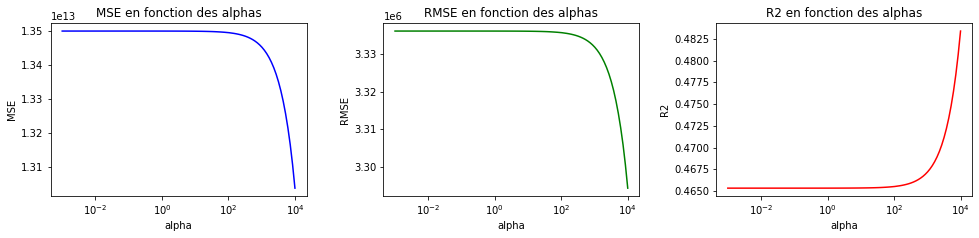

In [24]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

In [25]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 0, RMSE 0,  R2 99
Best fit is for alpha = 10000.0


In [26]:
lasso_regr.set_params(alpha=alphaBest)
lasso_regr.fit(xTrainScaled, yTrain)
yPredTrain = lasso_regr.predict(xTrainScaled)
yPredTest = lasso_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 5671281562383.09 RMSE 2381445.27 R2 0.772
MSE 5387703807156.84 RMSE 2321142.78 R2 0.786


In [27]:
# Store errors
Results.append(['Lasso with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

fold_number = 5
param_grid={"max_depth" : [3,4,5,6],
                "min_samples_leaf":[2,3,4,5,10],
                "min_samples_split":[10,15,20,25,30,40]
               # "max_features":[2,3,4]
               }
                    
dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr, param_grid,
              scoring='r2', cv=fold_number)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9723019063892329

In [29]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.984

In [30]:
grid_search.best_params_

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 15}

In [31]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']

In [32]:
dtr = DecisionTreeRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split= best_min_samples_split)
dtr.fit(xTrainScaled, yTrain)
yPredTrain = dtr.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = dtr.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 397800897271.81 RMSE 630714.59 R2 0.984
MSE 618991525859.06 RMSE 786760.15 R2 0.975


In [33]:
# Store errors
Results.append(['Decision Tree Regressor',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

fold_number = 5
param_grid={"max_depth" : [2,4,5],
                "min_samples_leaf":[2,5],
                "min_samples_split":[10,20],
                "n_estimators":[100,300,500],
                #"max_leaf_nodes":[16]
               # "max_features":[2,3,4]
               }
                    
rfg = RandomForestRegressor()
grid_search = GridSearchCV(rfg, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9759464278797626

In [35]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.986

In [36]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500}

In [37]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']

In [38]:
#rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
 #                                         max_leaf_nodes = best_max_leaf_nodes, min_samples_split= best_min_samples_split,
  #                                        n_estimators = best_n_estimators)
rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                           min_samples_split= best_min_samples_split,
                                          n_estimators = best_n_estimators)

rfg.fit(xTrainScaled, yTrain)
yPredTrain = rfg.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = rfg.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 345496266717.30 RMSE 587789.30 R2 0.986
MSE 457960486297.34 RMSE 676727.78 R2 0.982


In [39]:
# Store errors
Results.append(['Random Forest',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

fold_number = 5
param_grid={"max_depth" : [4,6],
            #"min_samples_leaf":[5,10],
            "min_samples_split":[10,20],
            "n_estimators":[300,600],
            #"max_leaf_nodes":[16],
            "learning_rate":[0.05,0.1],
            "n_iter_no_change":[10]
            
            # "max_features":[2,3,4]
               }
                    
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9810812821141806

In [41]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_samples_split': 10,
 'n_estimators': 600,
 'n_iter_no_change': 10}

In [42]:
best_depth = grid_search.best_params_['max_depth']
#best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_n_iter_no_change = grid_search.best_params_['n_iter_no_change']

In [43]:
#gbr = GradientBoostingRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                             #   max_leaf_nodes = best_max_leaf_nodes, min_samples_split= best_min_samples_split,
                             #   n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                             #   n_iter_no_change = best_n_iter_no_change)
gbr = GradientBoostingRegressor(max_depth=best_depth,
                                 min_samples_split= best_min_samples_split,
                                n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                                 n_iter_no_change = best_n_iter_no_change)

gbr.fit(xTrainScaled, yTrain)
yPredTrain = gbr.predict(xTrainScaled)
yPredTest = gbr.predict(xTestScaled)

msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 136660810079.08 RMSE 369676.63 R2 0.995
MSE 284426522147.26 RMSE 533316.53 R2 0.989


In [44]:
# Store errors
Results.append(['Gradient Boosting',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Comparaison des différents algorithmes

In [46]:
dfResults = pd.DataFrame(Results,columns=['Name','MSE Train','RMSE Train','R2 Train','MSE Test','RMSE Test','R2 Test'])
dfResults.round(3)

,Name,MSE Train,RMSE Train,R2 Train,MSE Test,RMSE Test,R2 Test
0,Linear Regression,5.666947e+12,2380534.991,0.772,5.418813e+12,2327834.432,0.784
1,RidgeCV,6.297666e+12,2509515.032,0.747,6.219610e+12,2493914.617,0.753
2,Ridge with Manual CV,6.297666e+12,2509515.032,0.747,6.219610e+12,2493914.617,0.753
3,LassoCV,5.928746e+12,2434901.705,0.762,5.448548e+12,2334212.473,0.783
4,Lasso with Manual CV,5.671282e+12,2381445.268,0.772,5.387704e+12,2321142.780,0.786
5,Decision Tree Regressor,3.978009e+11,630714.593,0.984,6.189915e+11,786760.145,0.975
6,Random Forest,3.454963e+11,587789.305,0.986,4.579605e+11,676727.779,0.982
7,Gradient Boosting,1.366608e+11,369676.629,0.995,2.844265e+11,533316.531,0.989


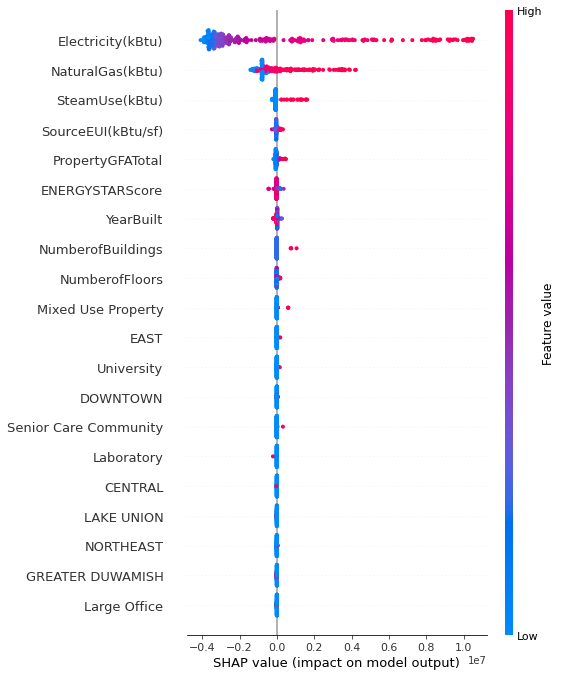

In [47]:
shap_values = shap.TreeExplainer(gbr).shap_values(xTestScaled)
shap.summary_plot(shap_values, xTestScaled,use_log_scale=False,feature_names=XTest.columns)

### 3. Modélisations sans l'Energy Star Score

In [48]:
XTrain = dfTrain.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1 )
yTrain = dfTrain[targetName].copy()
XTest = dfTest.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions','ENERGYSTARScore'],axis=1 )
yTest = dfTest[targetName].copy()

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

xTrainScaled = scaler.fit_transform(XTrain)
xTestScaled = scaler.transform(XTest)

#### Linear Regression

In [50]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression()
linear_regr.fit(xTrainScaled, yTrain)

yPredTrain = linear_regr.predict(xTrainScaled)
yPredTest = linear_regr.predict(xTestScaled)

In [51]:
msTrain,rmTrain,r2Train  = getRegressionMetrics(yPredTrain, yTrain)
msTest,rmTest,r2Test  = getRegressionMetrics(yPredTest, yTest)

MSE 5673494758015.46 RMSE 2381909.90 R2 0.772
MSE 5436063099259.60 RMSE 2331536.64 R2 0.784


In [52]:
# Store errors
Results = []
Results.append(['Linear Regression',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### RidgeCV

In [53]:
from sklearn.linear_model import RidgeCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

ridgeCV_regr = RidgeCV(alphas=alphas,
scoring='neg_mean_squared_error',
                 cv=fold_number)
ridgeCV_regr.fit(xTrainScaled, yTrain)
print('alpha = {}  best score = {}'.format(ridgeCV_regr.alpha_ , ridgeCV_regr.best_score_))
yPredtrain = ridgeCV_regr.predict(xTrainScaled)
print('Train best score = {}'.format(ridgeCV_regr.score(xTrainScaled,yTrain)))
yPredTest = ridgeCV_regr.predict(xTestScaled)
print('Test best score = {}'.format(ridgeCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

alpha = 475.0810162102793  best score = -7590361365281.028
Train best score = 0.7471950344254567
Test best score = 0.7534682211953336
MSE 6285675791103.84 RMSE 2507125.01 R2 0.747
MSE 6197849351161.46 RMSE 2489548.02 R2 0.753


In [54]:
# Store errors
Results.append(['RidgeCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Ridge  with Manual CV

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from numpy import mean , std

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

In [56]:
TabErrors = []
ridge_regr = Ridge()

for i,a in enumerate(alphas) :
    ridge_regr.set_params(alpha=a)
    scores = cross_validate(ridge_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)

#mini = [val[0] for i,val in enumerate(TabErrors) if val[1] == np.min(TabErrors,axis=0)[1]]
#mini

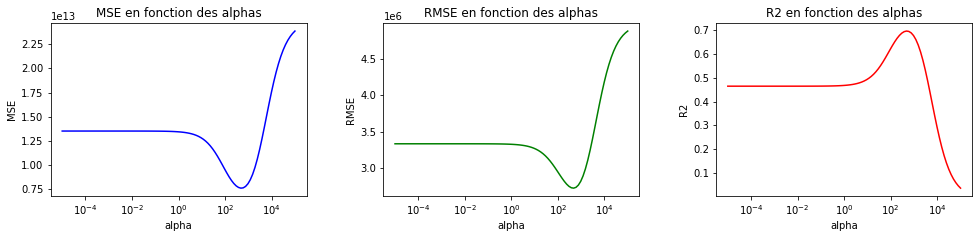

In [57]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

Get best params

In [58]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 99, RMSE 99,  R2 76
Best fit is for alpha = 475.0810162102793


Apply model with best params

In [59]:
ridge_regr.set_params(alpha=alphaBest)
ridge_regr.fit(xTrainScaled, yTrain)
yPredTrain = ridge_regr.predict(xTrainScaled)
yPredTest = ridge_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 6285675791103.84 RMSE 2507125.01 R2 0.747
MSE 6197849351161.46 RMSE 2489548.02 R2 0.753


In [60]:
# Store errors
Results.append(['Ridge with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### LassoCV

In [61]:
from sklearn.linear_model import LassoCV

nAlphas = 100
fold_number = 5
alphas= np.logspace(-5,5,nAlphas)

lassoCV_regr = LassoCV(alphas=alphas, cv=fold_number)

lassoCV_regr.fit(xTrainScaled, yTrain)
print('Best fit is for alpha = {}'.format(lassoCV_regr.alpha_))
yPredtrain = lassoCV_regr.predict(xTrainScaled)
print('Train best score = {:.3f}'.format(lassoCV_regr.score(xTrainScaled,yTrain)))
yPredTest = lassoCV_regr.predict(xTestScaled)
print('Test best score = {:.3f}'.format(lassoCV_regr.score(xTestScaled,yTest)))
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredtrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

Best fit is for alpha = 100000.0
Train best score = 0.762
Test best score = 0.783
MSE 5928758785759.61 RMSE 2434904.27 R2 0.762
MSE 5448570959774.76 RMSE 2334217.42 R2 0.783


In [62]:
# Store errors
Results.append(['LassoCV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Lasso with Manual CV

In [63]:
from sklearn.linear_model import Lasso

n_alphas = 100
alphas = np.logspace(-3, 4, n_alphas)

In [64]:
TabErrors = []
lasso_regr = Lasso()

for i,a in enumerate(alphas) :
    lasso_regr.set_params(alpha=a)
    scores = cross_validate(lasso_regr, xTrainScaled, yTrain, cv=fold_number,
                            scoring=('neg_mean_squared_error','neg_root_mean_squared_error','r2'))
    temp = a, -mean(scores['test_neg_mean_squared_error']), -mean(scores['test_neg_root_mean_squared_error']), mean(scores['test_r2'])
    TabErrors.append(temp)


Objective did not converge. You might want to increase the number of iterations. Duality gap: 225628558905342.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311436280590041.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396206321439228.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854717822852357.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562360994480434.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225628548692786.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311436394022951.0, tolerance: 2594247679393.997
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 854717825673379.5, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562361026346233.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225628570666766.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311436416437548.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396206369698972.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854717837334275.5, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562361022030397.0, tolerance: 2604951807635.925
Obj

Objective did not converge. You might want to increase the number of iterations. Duality gap: 562361278761127.5, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225628798632140.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311436644372868.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396206664461618.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854718208612682.5, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562361334026068.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225628845777788.0, tolerance: 2555587343784.163
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 311438218866883.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396208682082755.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854720874542112.5, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562363521148561.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225630729329614.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311438542844063.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396209098184916.5, tolerance: 2651305075165.9556
Obj

Objective did not converge. You might want to increase the number of iterations. Duality gap: 396222815543681.5, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 626493142583162.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 562378893855590.0, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 225643920946697.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 311451568590488.5, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396225702665237.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 626496517968975.0, tolerance: 2719329453221.5215
Ob

Objective did not converge. You might want to increase the number of iterations. Duality gap: 209927443013536.0, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220371291649241.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 396308642951037.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 199848449954144.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 185405737210143.5, tolerance: 2604951807635.925
Objective did not converge. You might want to increase the number of iterations. Duality gap: 209941568628516.5, tolerance: 2555587343784.163
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220384054853199.0, tolerance: 2594247679393.997
Obje

Objective did not converge. You might want to increase the number of iterations. Duality gap: 19816874823958.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 30948457814512.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 83354021888221.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19842942091358.0, tolerance: 2651305075165.9556
Objective did not converge. You might want to increase the number of iterations. Duality gap: 30982347630771.0, tolerance: 2719329453221.5215
Objective did not converge. You might want to increase the number of iterations. Duality gap: 83415337054336.0, tolerance: 2594247679393.997
Objective did not converge. You might want to increase the number of iterations. Duality gap: 83486834512388.0, tolerance: 2594247679393.997
Objective

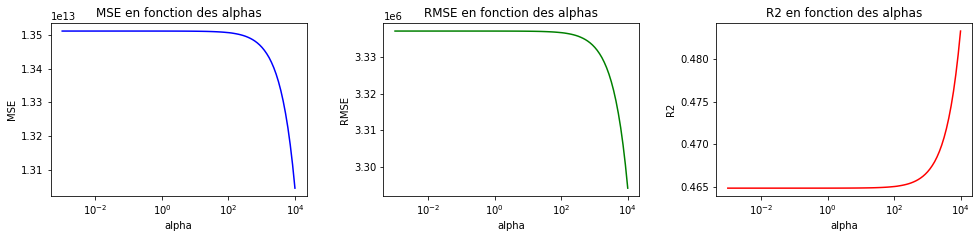

In [65]:
fig, axes = plt.subplots(1, 3,figsize=(16,3))
tab = ['MSE','RMSE','R2']
color = ['b','g','r']

for i,error_name in enumerate(tab) :
    error_liste = [name[i+1] for j,name in enumerate(TabErrors)]
    axes[i].plot(alphas,  error_liste,c=color[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('alpha')
    axes[i].set_ylabel(error_name)
    axes[i].set_title(tab[i] + ' en fonction des alphas')
    
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, 
                    wspace=0.3, hspace=0.2)

plt.show()

In [66]:
dfErrors = pd.DataFrame(TabErrors,columns=['alpha','MSE','RMSE','R2'])
imin = dfErrors['R2'].idxmax()
print('Index values for MSE {}, RMSE {},  R2 {}'
      .format(dfErrors['MSE'].idxmax(),dfErrors['MSE'].idxmax(),imin  )   )
alphaBest = dfErrors.loc[imin,'alpha']
print('Best fit is for alpha = {}'.format(alphaBest))

Index values for MSE 0, RMSE 0,  R2 99
Best fit is for alpha = 10000.0


In [67]:
lasso_regr.set_params(alpha=alphaBest)
lasso_regr.fit(xTrainScaled, yTrain)
yPredTrain = lasso_regr.predict(xTrainScaled)
yPredTest = lasso_regr.predict(xTestScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 5677414891688.73 RMSE 2382732.65 R2 0.772
MSE 5400809422763.28 RMSE 2323964.16 R2 0.785


In [68]:
# Store errors
Results.append(['Lasso with Manual CV',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Decision Tree Regressor

In [69]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

fold_number = 5
param_grid={"max_depth" : [2,3,4,5,6],
                "min_samples_leaf":[2,3,4,5,10],
                "min_samples_split":[10,15,20,25,30,40]
               # "max_features":[2,3,4]
               }
                    
dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(dtr, param_grid,
              scoring='r2', cv=fold_number)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9724253226790948

In [70]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.986

In [71]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']

In [72]:
dtr = DecisionTreeRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                                         min_samples_split= best_min_samples_split)
dtr.fit(xTrainScaled, yTrain)
yPredTrain = dtr.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = dtr.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 355656192487.71 RMSE 596369.17 R2 0.986
MSE 616802649617.57 RMSE 785367.84 R2 0.975


In [73]:
# Store errors
Results.append(['Decision Tree Regressor',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor

fold_number = 5
param_grid={"max_depth" : [2,4,5],
                "min_samples_leaf":[2,5],
                "min_samples_split":[10,20],
                "n_estimators":[100,300,500],
                #"max_leaf_nodes":[16]
               # "max_features":[2,3,4]
               }
                    
rfg = RandomForestRegressor()
grid_search = GridSearchCV(rfg, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9758137855608349

In [75]:
grid_search.score(xTrainScaled, yTrain).round(3)

0.986

In [76]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [77]:
best_depth = grid_search.best_params_['max_depth']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']

In [78]:
rfg = RandomForestRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,
                            min_samples_split= best_min_samples_split, n_estimators = best_n_estimators)
rfg.fit(xTrainScaled, yTrain)
yPredTrain = rfg.predict(xTrainScaled)
msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
yPredTest = rfg.predict(xTestScaled)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 358288736614.20 RMSE 598572.25 R2 0.986
MSE 434230142175.77 RMSE 658961.41 R2 0.983


In [79]:
# Store errors
Results.append(['Random Forest',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

fold_number = 5
param_grid={"max_depth" : [4,6],
            #"min_samples_leaf":[5,10],
            "min_samples_split":[10,20],
            "n_estimators":[300,600],
            #"max_leaf_nodes":[16],
            "learning_rate":[0.05,0.1],
            "n_iter_no_change":[10]
            
            # "max_features":[2,3,4]
               }
                    
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(gbr, param_grid,
              scoring='r2', cv=fold_number,n_jobs=-1)

grid_search.fit(xTrainScaled, yTrain)
grid_search.best_score_

0.9816503378611585

In [81]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'min_samples_split': 10,
 'n_estimators': 300,
 'n_iter_no_change': 10}

In [82]:
best_depth = grid_search.best_params_['max_depth']
#best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_min_samples_split = grid_search.best_params_['min_samples_split']
#best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_n_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_n_iter_no_change = grid_search.best_params_['n_iter_no_change']

In [83]:
gbr = GradientBoostingRegressor(max_depth=best_depth,min_samples_split= best_min_samples_split,
                                n_estimators = best_n_estimators, learning_rate = best_learning_rate,
                                 n_iter_no_change = best_n_iter_no_change)
gbr.fit(xTrainScaled, yTrain)
yPredTrain = gbr.predict(xTrainScaled)
yPredTest = gbr.predict(xTestScaled)

msTrain,rmTrain,r2Train = getRegressionMetrics(yPredTrain, yTrain, isDump=True)
msTest,rmTest,r2Test = getRegressionMetrics(yPredTest, yTest, isDump=True)

MSE 21223416170.86 RMSE 145682.59 R2 0.999
MSE 375653567352.17 RMSE 612905.84 R2 0.985


In [84]:
# Store errors
Results.append(['Gradient Boosting',msTrain,rmTrain,r2Train,msTest,rmTest,r2Test])

#### Comparaison des différents algorithmes

In [85]:
dfResults = pd.DataFrame(Results,columns=['Name','MSE Train','RMSE Train','R2 Train','MSE Test','RMSE Test','R2 Test'])
dfResults.round(3)

,Name,MSE Train,RMSE Train,R2 Train,MSE Test,RMSE Test,R2 Test
0,Linear Regression,5.673495e+12,2381909.897,0.772,5.436063e+12,2331536.639,0.784
1,RidgeCV,6.285676e+12,2507125.005,0.747,6.197849e+12,2489548.021,0.753
2,Ridge with Manual CV,6.285676e+12,2507125.005,0.747,6.197849e+12,2489548.021,0.753
3,LassoCV,5.928759e+12,2434904.266,0.762,5.448571e+12,2334217.419,0.783
4,Lasso with Manual CV,5.677415e+12,2382732.652,0.772,5.400809e+12,2323964.161,0.785
5,Decision Tree Regressor,3.556562e+11,596369.175,0.986,6.168026e+11,785367.844,0.975
6,Random Forest,3.582887e+11,598572.248,0.986,4.342301e+11,658961.412,0.983
7,Gradient Boosting,2.122342e+10,145682.587,0.999,3.756536e+11,612905.839,0.985


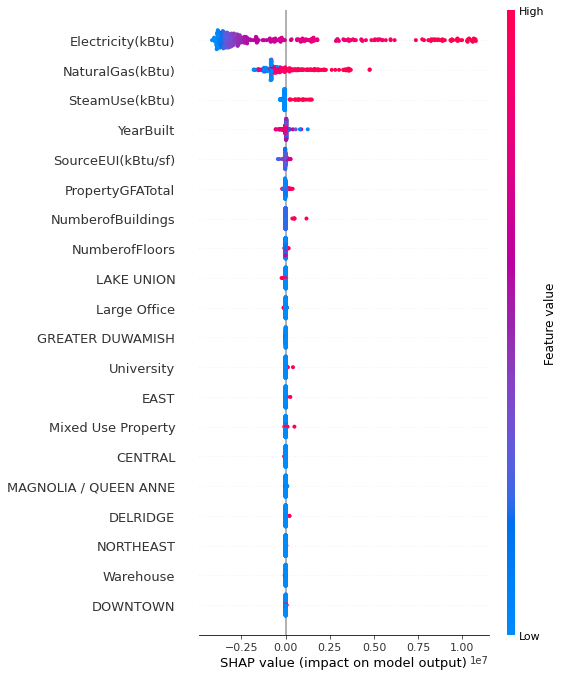

In [86]:
shap_values = shap.TreeExplainer(gbr).shap_values(xTestScaled)
shap.summary_plot(shap_values, xTestScaled,use_log_scale=False,feature_names=XTest.columns)